# SIFT na OpenCV

Este documento discute brevemente como se trabalhar com a detecção de features SIFT na OpenCV.

Fontes:

- [OpenCV: Introduction to SIFT](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)
- [OpenCV: SIFT Class Reference](https://docs.opencv.org/4.x/d7/d60/classcv_1_1SIFT.html)
- [Feature Matching](https://docs.opencv.org/4.8.0/dc/dc3/tutorial_py_matcher.html)


## 1. Detection

O código a seguir mostra como utilizar a classe `SIFT` e o método
`detect`,  para detectar pontos.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def imprime_pontos(kpts):
    '''
    Imprime informações sobre keypoints.
    '''
    
    print('Keypoints:')
    for kp in kpts:
        print(f'\t({kp.pt[0]:.2f}, {kp.pt[1]:.2f}), escala: {kp.size:.2f}, orientação: {kp.angle:.2f}')
    
def main():
    
    img = cv2.imread('samples/eiffel_tower1.jpg')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    print(f'Octaves: {sift.getNOctaveLayers()}')
    print(f'Sigma: {sift.getSigma()}')
    print(f'EdgeThr: {sift.getEdgeThreshold()}')
    print(f'ContrastThr: {sift.getContrastThreshold()}')
    
    kpts = sift.detect(img_gray, None) # detect: detecta pontos SIFT. o 2o. parâmetro é uma máscara (imagem binária que indica onde detectar pontos)
    imprime_pontos(kpts)
    
    img_view = img.copy() # cria cópia da imagem de entrada para visualização
    cv2.drawKeypoints(img, kpts, img_view, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # desenha keypoints na visualização
    
    plt.figure().set_figheight(600)
    plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB))
    plt.show()
    
if __name__ == '__main__':
    main()

## 2. Description

O código a seguir mostra como utilizar o método
`compute` da classe `SIFT`. Este método é utilizado para computar
os descritores de cada ponto, assumindo que estes já foram
computados previamente.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from numpy import linalg as LA

def imprime_descritores(desc):
    '''
    Imprime os descritores dos pontos.
    '''
    
    print('Descritores:')
    for d in desc:
        print(f'\t{d}, norm: {LA.norm(d)}')
    
def main():
    
    img = cv2.imread('samples/eiffel_tower1.jpg')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    
    kpts = sift.detect(img_gray, None) # detecta pontos, como mostrado anteriormente
    kpts, desc = sift.compute(img_gray, kpts) # computa descritores para keypoints dados. observe que novos keypoints podem ser criados neste ponto
    imprime_descritores(desc) # desc é uma matriz MxN: M descritores de tamanho N (128 no caso do SIFT)
    
if __name__ == '__main__':
    main()

Também, é possível computar os pontos e descritores SIFT
em uma única função.
Isto é feito com o método `detectAndCompute` da classe `SIFT`,
como mostrado a seguir.

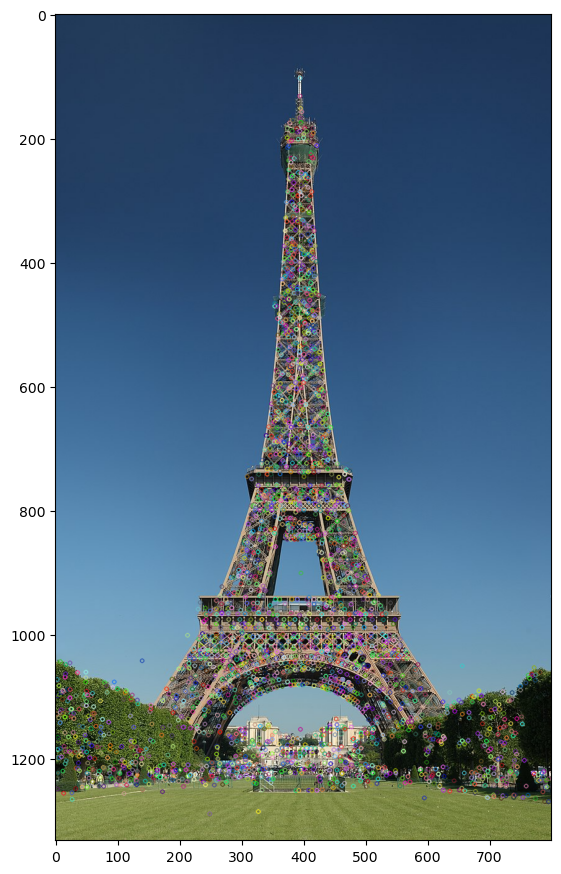

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
    
def main():
    
    img = cv2.imread('samples/eiffel_tower1.jpg')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    kpts, desc = sift.detectAndCompute(img_gray, None) # detect: detecta pontos SIFT e seus descritores
    
    img_view = img.copy()
    cv2.drawKeypoints(img, kpts, img_view)
    
    plt.figure().set_figheight(600)
    plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB))
    plt.show()
    
if __name__ == '__main__':
    main()

## 3. Correspondência Entre Features

Uma etapa frequente em algoritmos de Visão Computacional
que trabalham com features do tipo pontos é
estabelecer a correspondência entre pontos detectados
em diferentes imagens.

O código a seguir detecta pontos/extrai descritores SIFT de duas
imagens, obtém correspondências entre os descritores e exibe
visualmente o resultado.

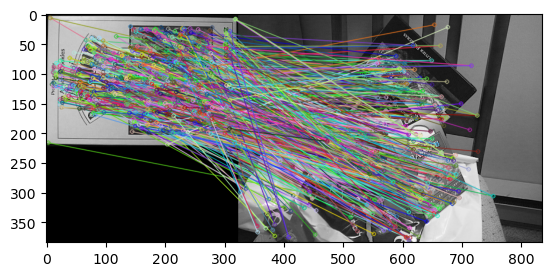

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
    
def main():
    
    img1 = cv2.imread('samples/box.png')
    img_gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread('samples/box_in_scene.png')
    img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    #sift.setNFeatures(50) #atribui máximo de features -> apenas para visualização
    kpts1, desc1 = sift.detectAndCompute(img_gray1, None)
    kpts2, desc2 = sift.detectAndCompute(img_gray2, None)
    
    bf = cv2.BFMatcher() # cria objeto que obtém as correspondências por força bruta:
                         # para cada ponto na img1, calcula a dist. para os descritores da img2
                         # e forma correspondência com o ponto de descritor mais próximo
    matches = bf.knnMatch(desc1, desc2, k=1) # nr. de distâncias (vizinhos mais próximos)
    # também existe a possibilidade de utilizar bf.match
    
    img_view = cv2.drawMatchesKnn(img1, kpts1, img2, kpts2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) # desenha matches: veja que os matches a serem desenhados é uma lista de lista
    
    plt.figure().set_figheight(600)
    plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB))
    plt.show()
    
if __name__ == '__main__':
    main()

Uma heurística bastante utilizada para computar boas correspondências
é comparar a distância entre um descritor da imagem1 e os dois melhores
descritores da imagem2.

Considere $d1$ a distância entre um descritor da imagem 1 e o descritor mais próximo a ele da imagem 2
e $d2$ como sendo a distância entre um descritor da imagem 1 e o segundo descritor mais próximo a ele da imagem 2.
Caso a razão entre $d1$ e $d2$ seja maior ou igual a um valor $k$, a correspondência é rejeitada.

O código a seguir implementa esta filtragem.

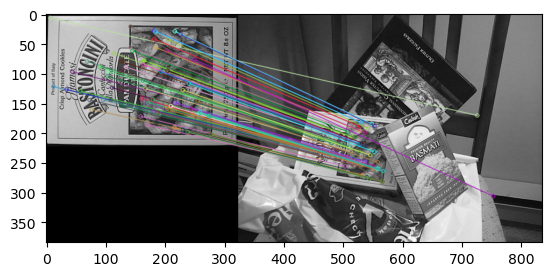

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
    
def main():
    
    img1 = cv2.imread('samples/box.png')
    img_gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread('samples/box_in_scene.png')
    img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    kpts1, desc1 = sift.detectAndCompute(img_gray1, None)
    kpts2, desc2 = sift.detectAndCompute(img_gray2, None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2) # calcula as 2 distâncias mais próximas.
    
    # filtra correspondências: rejeita as que tem uma 2a distância mais próxima menor do que K x a 1a distância
    k = 0.75
    filtered_matches = []
    for m, n in matches:
        if m.distance < k*n.distance:
            filtered_matches.append([m])
    
    img_view = cv2.drawMatchesKnn(img1, kpts1, img2, kpts2, filtered_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure().set_figheight(600)
    plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB))
    plt.show()
    
if __name__ == '__main__':
    main()